# Enhanced Domain-Aware Analysis Approach

## Addressing Domain Imbalance

Our refined methodology tackles the dataset's inherent domain imbalance:

- **Stratified Analysis**: 
  - Separates evaluation between balanced domains (News/Politics) and the imbalanced domain (Other) to ensure fair assessment.

- **Appropriate Metrics**: 
  - Utilizes a comprehensive metric suite for News and Politics, while focusing on accuracy for the Other domain, where precision is artificially high due to class imbalance.

- **Tailored Feature Analysis**:
  - For News and Politics: Employs standard XGBoost feature importance to identify key predictors.
  - For Other: Conducts word frequency distribution analysis to avoid misleading interpretations from model coefficients.

- **Domain-Specific Visualizations**:
  - Generates confusion matrices for News and Politics to illustrate error patterns and model performance.
  - Creates prediction distribution plots for the Other domain to assess confidence levels in predictions.

- **Holistic Evaluation**: 
  - Maintains aggregate metrics while providing domain-specific insights to ensure a comprehensive understanding of model performance.

This approach delivers more reliable insights by acknowledging and adapting to the structural limitations in the dataset, particularly the absence of true news examples in the "Other" category.

In [1]:
# Install required packages with specific versions
# !pip install numpy==1.24.3
# !pip install pandas==2.0.3
# !pip install nltk==3.8.1
# !pip install -U scikit-learn==1.3.0
# !pip install xgboost==2.0.0
# !pip install tensorflow==2.11.0
# !pip install matplotlib==3.7.2
# !pip install seaborn==0.12.2
# !pip install textstat==0.7.3
# !pip install lightgbm==4.1.0
# !pip install catboost==1.2.2
# !!pip install textstat==0.7.3

# Download required NLTK data
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('wordnet')

In [2]:
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns
import textstat
from scipy.sparse import hstack, csr_matrix

In [3]:
true_news = pd.read_csv('../data/True.csv')
fake_news = pd.read_csv('../data/Fake.csv')

In [4]:
domain_map = {
    'politicsNews': 'Politics',
    'worldnews': 'News',
    'News': 'News',
    'left-news': 'Other',
    'Government News': 'Other',
    'US_News': 'Other',
    'Middle-east': 'Other',
    'politics':'Politics'
}

true_news['subject'] = true_news['subject'].map(domain_map)
fake_news['subject'] = fake_news['subject'].map(domain_map)

In [5]:
true_df = pd.concat([true_news['title'], true_news['text'], true_news['subject'], 
                     pd.Series(0, index=true_news.index, name='label')], axis=1)
fake_df = pd.concat([fake_news['title'], fake_news['text'], fake_news['subject'], 
                     pd.Series(1, index=fake_news.index, name='label')], axis=1)

news_df = pd.concat([true_df, fake_df], axis=0).sample(frac=1.0, random_state=34).reset_index(drop=True)

print("\nCombined dataset subjects distribution:")
print(news_df['subject'].value_counts())
print("\nLabel distribution by subject:")
print(pd.crosstab(news_df['subject'], news_df['label']))


Combined dataset subjects distribution:
News        19195
Politics    18113
Other        7590
Name: subject, dtype: int64

Label distribution by subject:
label         0     1
subject              
News      10145  9050
Other         0  7590
Politics  11272  6841


In [6]:
valid_domains = ['News', 'Politics']
other_domain = 'Other'

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation_table = str.maketrans('', '', string.punctuation)

def enhanced_text_processing(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Replace URLs with 'url'
    text = re.sub(r'https?://\S+|www\.\S+', 'url', text)
    
    # Replace dollar signs and amounts with 'money'
    text = re.sub(r'\$\d+(?:\.\d+)?|\d+\s?dollars?', 'money', text)
    
    # Replace numbers with 'number'
    text = re.sub(r'\d+(?:\.\d+)?', 'number', text)
    
    # Remove punctuation
    text = text.translate(punctuation_table)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    
    return ' '.join(tokens)

In [8]:
news_df['processed_title'] = news_df['title'].apply(enhanced_text_processing)
news_df['processed_text'] = news_df['text'].apply(enhanced_text_processing)

# Enhanced Feature Extraction Process

## Title Features
- **Title Length**: Measures the total number of characters in the title.
- **Title Word Count**: Counts the number of words in the title.
- **Title Capital Ratio**: Calculates the ratio of uppercase letters to the total length of the title, providing insight into the emphasis within the title.

## Text Features
- **Text Length**: Measures the total number of characters in the text.
- **Text Word Count**: Counts the number of words in the text.
- **Text Capital Ratio**: Similar to the title, this ratio indicates the emphasis in the text.
- **Text Sentence Count**: Counts the number of sentences based on punctuation marks (., !, ?).

## Readability Scores
- **Flesch Reading Ease**: A score indicating how easy the text is to read.
- **SMOG Index**: Estimates the years of education needed to understand the text.
- **Flesch-Kincaid Grade**: Provides a U.S. school grade level for the text.

## Sentiment and Style Features
- **Exclamation Count**: Counts the number of exclamation marks, indicating emotional intensity.
- **Question Count**: Counts the number of question marks, reflecting inquiry or uncertainty.
- **Quote Count**: Counts the number of quotation marks, which may indicate direct speech or references.

In [9]:
def extract_text_features(title, text):
    if not isinstance(title, str):
        title = ""
    if not isinstance(text, str):
        text = ""
    
    features = {}
    
    # Title features
    features['title_length'] = len(title)
    features['title_word_count'] = len(title.split())
    features['title_capital_ratio'] = sum(1 for c in title if c.isupper()) / (len(title) + 1)
    
    # Text features
    features['text_length'] = len(text)
    features['text_word_count'] = len(text.split())
    features['text_capital_ratio'] = sum(1 for c in text if c.isupper()) / (len(text) + 1)
    features['text_sentence_count'] = text.count('.') + text.count('!') + text.count('?')
    
    # Readability scores
    features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
    features['smog_index'] = textstat.smog_index(text)
    features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
    
    # Sentiment and style features
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['quote_count'] = text.count('"') + text.count("'")
    
    return features

text_features = news_df.apply(
    lambda row: extract_text_features(row['title'], row['text']), 
    axis=1
)

text_features_df = pd.DataFrame(text_features.tolist())

In [10]:
# Combine title and text with more weight on title
news_df['combined_text'] = news_df['processed_title'] + " " + news_df['processed_title'] + " " + news_df['processed_text']

# Create domain encoding
news_df['domain_encoded'] = news_df['subject'].map({'News': 0, 'Politics': 1, 'Other': 2})

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    news_df[['combined_text', 'subject', 'domain_encoded']].join(text_features_df),
    news_df['label'],
    test_size=0.25,
    random_state=42,
    stratify=news_df[['subject', 'label']]
)

# Check distribution in train and test sets
print("\nTrain set subject distribution:")
print(X_train['subject'].value_counts())
print("\nTest set subject distribution:")
print(X_test['subject'].value_counts())



Train set subject distribution:
News        14396
Politics    13585
Other        5692
Name: subject, dtype: int64

Test set subject distribution:
News        4799
Politics    4528
Other       1898
Name: subject, dtype: int64


# Enhanced Text Vectorization Features

replaced BoW approach in baseline to an advanced feature extraction method using TF-IDF and character n-grams. This change allows for better representation of the text data, capturing both word importance and character-level patterns.

## TF-IDF Vectorization
utilized the **TF-IDF Vectorizer** to transform the combined text data into numerical features, focusing on the following parameters:
- **Max Features**: Limited to 5,000 to reduce dimensionality.
- **Minimum Document Frequency (min_df)**: Set to 5 to ignore terms that appear in fewer than 5 documents.
- **Maximum Document Frequency (max_df)**: Set to 0.8 to exclude terms that appear in more than 80% of the documents.
- **N-gram Range**: Included both unigrams and bigrams to capture word combinations.

In [12]:
print("Creating text vectorization features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['combined_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['combined_text'])

# Create Count Vectorizer features for character n-grams
char_vectorizer = CountVectorizer(
    analyzer='char',
    ngram_range=(2, 5),
    max_features=3000
)

X_train_char = char_vectorizer.fit_transform(X_train['combined_text'])
X_test_char = char_vectorizer.transform(X_test['combined_text'])

# Combine all features
X_train_text_features = csr_matrix(X_train.drop(['combined_text', 'subject'], axis=1).values)
X_test_text_features = csr_matrix(X_test.drop(['combined_text', 'subject'], axis=1).values)

X_train_combined = hstack([X_train_tfidf, X_train_char, X_train_text_features])
X_test_combined = hstack([X_test_tfidf, X_test_char, X_test_text_features])

print(f"Final feature matrix shape: {X_train_combined.shape}")

Creating text vectorization features...
Final feature matrix shape: (33673, 8014)


# Domain Weighting Strategy

To address class imbalance, I used a domain-specific weighting strategy:

1. **Class Weights Calculation**:
   - For each domain, the total samples, true news count, and fake news count are computed.
   - For the "Other" domain (only fake news), weights are set to `{0: 0.0, 1: 1.0}`.
   - For other domains:
     - True news weight: 
       $$
       \text{Weight}_{0} = \frac{\text{Total}}{2 \times \text{True Count}}
       $$
     - Fake news weight: 
       $$
       \text{Weight}_{1} = \frac{\text{Total}}{2 \times \text{Fake Count}}
       $$

2. **Sample Weights**:
   - Created an array of sample weights for the training set based on the calculated domain weights.

In [13]:
domain_weights = {}
for domain in news_df['subject'].unique():
    # Calculate class weights within each domain
    domain_data = news_df[news_df['subject'] == domain]
    total = len(domain_data)
    fake_count = sum(domain_data['label'])
    true_count = total - fake_count
    
    # For "Other" domain which only has fake news
    if domain == 'Other':
        domain_weights[domain] = {0: 0.0, 1: 1.0}  # Only fake news exists
    else:
        # Balance weights within domain
        if true_count > 0 and fake_count > 0:
            domain_weights[domain] = {
                0: total / (2 * true_count),
                1: total / (2 * fake_count)
            }
        else:
            domain_weights[domain] = {0: 1.0, 1: 1.0}

sample_weights_train = np.ones(len(X_train))
for i, (domain, label) in enumerate(zip(X_train['subject'], y_train)):
    sample_weights_train[i] = domain_weights[domain][label]

# Ensemble Model Training

## XGBoost Model
- **Parameters**: Configured for binary classification with an AUC evaluation metric. Key parameters include:
  - `max_depth`: 6
  - `eta`: 0.1 (learning rate)
  - `subsample` and `colsample_bytree`: 0.8 to prevent overfitting.
  - `tree_method`: 'hist' for faster training.
- **Training**: Utilized a DMatrix for efficient data handling, incorporating sample weights to address class imbalance.

## LightGBM Model
- **Parameters**: Set for binary classification with AUC as the metric. Important parameters include:
  - `num_leaves`: 31
  - `learning_rate`: 0.05
  - `feature_fraction` and `bagging_fraction`: 0.9 and 0.8, respectively, to enhance generalization.
- **Training**: Used a LightGBM dataset with sample weights to ensure balanced learning.

## CatBoost Model
- **Parameters**: Configured for binary classification with a focus on handling categorical features effectively. Key parameters include:
  - `iterations`: 100
  - `learning_rate`: 0.1
  - `depth`: 6
- **Training**: Employed a Pool object for training, which allows for efficient handling of sample weights.

These ensemble models were trained to improve predictive performance and robustness, particularly in the context of class imbalance in the dataset.

In [15]:
# Train ensemble models
print("Training ensemble models...")

# XGBoost model
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'tree_method': 'hist'  # For faster training
}

dtrain = xgb.DMatrix(X_train_combined, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test_combined, label=y_test)

xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100,
    verbose_eval=False
)

# LightGBM model
lgb_train = lgb.Dataset(X_train_combined, y_train, weight=sample_weights_train)

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=100
)

# CatBoost model
cat_train = Pool(X_train_combined, y_train, weight=sample_weights_train)

cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=False
)

cat_model.fit(cat_train)

Training ensemble models...
[LightGBM] [Info] Number of positive: 17610, number of negative: 16063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.373863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 909364
[LightGBM] [Info] Number of data points in the train set: 33673, number of used features: 8014
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.584512 -> initscore=0.341324
[LightGBM] [Info] Start training from score 0.341324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [17]:
xgb_pred_proba = xgb_model.predict(dtest)
lgb_pred_proba = lgb_model.predict(X_test_combined)
cat_pred_proba = cat_model.predict_proba(X_test_combined)[:, 1]

# Ensemble predictions (simple average)
ensemble_pred_proba = (xgb_pred_proba + lgb_pred_proba + cat_pred_proba) / 3
ensemble_pred = (ensemble_pred_proba > 0.5).astype(int)

# Calculate overall metrics
accuracy = accuracy_score(y_test, ensemble_pred)
precision = precision_score(y_test, ensemble_pred)
recall = recall_score(y_test, ensemble_pred)
f1 = f1_score(y_test, ensemble_pred)

print("\nOverall Ensemble Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nIndividual Model Performance:")
for name, preds in [
    ('XGBoost', (xgb_pred_proba > 0.5).astype(int)),
    ('LightGBM', (lgb_pred_proba > 0.5).astype(int)),
    ('CatBoost', (cat_pred_proba > 0.5).astype(int)),
    ('Ensemble', ensemble_pred)
]:
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f"{name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

# Create a DataFrame with predictions for domain-specific analysis
test_results = X_test[['subject']].copy()
test_results['true_label'] = y_test.values
test_results['predicted_label'] = ensemble_pred
test_results['predicted_proba'] = ensemble_pred_proba


Overall Ensemble Model Performance:
Accuracy: 0.9994
Precision: 0.9995
Recall: 0.9993
F1 Score: 0.9994

Individual Model Performance:
XGBoost: Acc=0.9994, Prec=0.9997, Rec=0.9991, F1=0.9994
LightGBM: Acc=0.9993, Prec=0.9993, Rec=0.9993, F1=0.9993
CatBoost: Acc=0.9988, Prec=0.9985, Rec=0.9993, F1=0.9989
Ensemble: Acc=0.9994, Prec=0.9995, Rec=0.9993, F1=0.9994


# Model Performance Summary

## Overall Ensemble Model Performance

| Metric     | Score   |
|------------|---------|
| Accuracy   | 0.9994  |
| Precision  | 0.9995  |
| Recall     | 0.9993  |
| F1 Score   | 0.9994  |

## Individual Model Performance

| Model      | Accuracy | Precision | Recall | F1 Score |
|------------|----------|-----------|--------|----------|
| XGBoost    | 0.9994   | 0.9997    | 0.9991 | 0.9994   |
| LightGBM   | 0.9993   | 0.9993    | 0.9993 | 0.9993   |
| CatBoost   | 0.9988   | 0.9985    | 0.9993 | 0.9989   |
| Ensemble    | 0.9994   | 0.9995    | 0.9993 | 0.9994   |

## Caution on Overfitting
While the performance metrics indicate considerable improvement over the baseline model, it is crucial to remain cautious about the potential for overfitting. Given the high scores achieved, there is a risk that the models may not generalize well to unseen data. Due to time constraints, further exploration of overfitting and model validation techniques has not been conducted. If I had more time, I would start by implementing cross-validation.


Performance by Domain:

News Domain:
  Accuracy: 0.9990
  Precision: 0.9991
  Recall: 0.9987
  F1 Score: 0.9989

Politics Domain:
  Accuracy: 0.9996
  Precision: 0.9994
  Recall: 0.9994
  F1 Score: 0.9994

Other Domain (Fake News Only):
  Accuracy: 1.0000
  Note: This domain only contains fake news, so precision/recall/F1 are not applicable


<Figure size 1200x800 with 0 Axes>

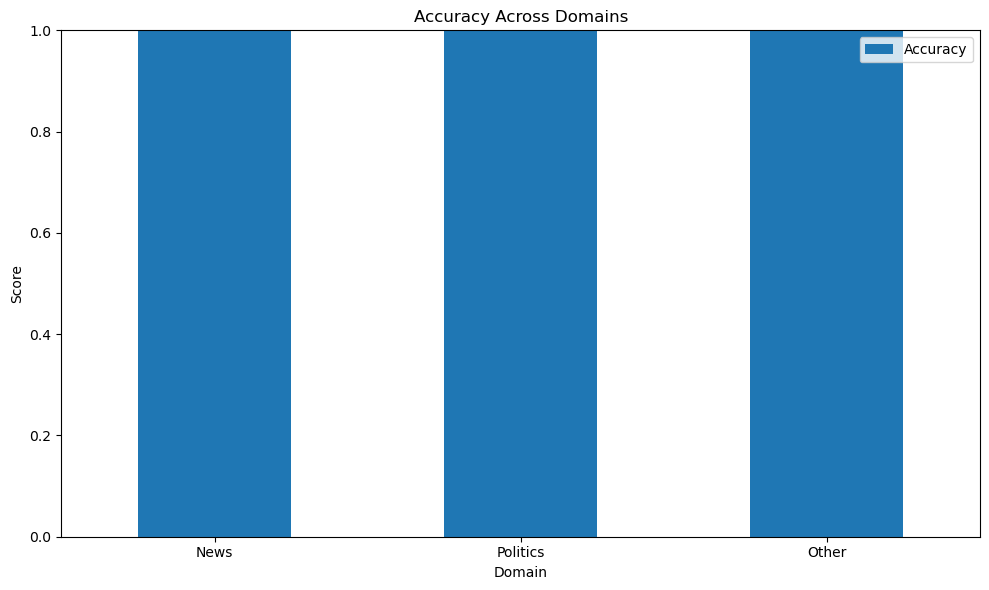

<Figure size 1200x800 with 0 Axes>

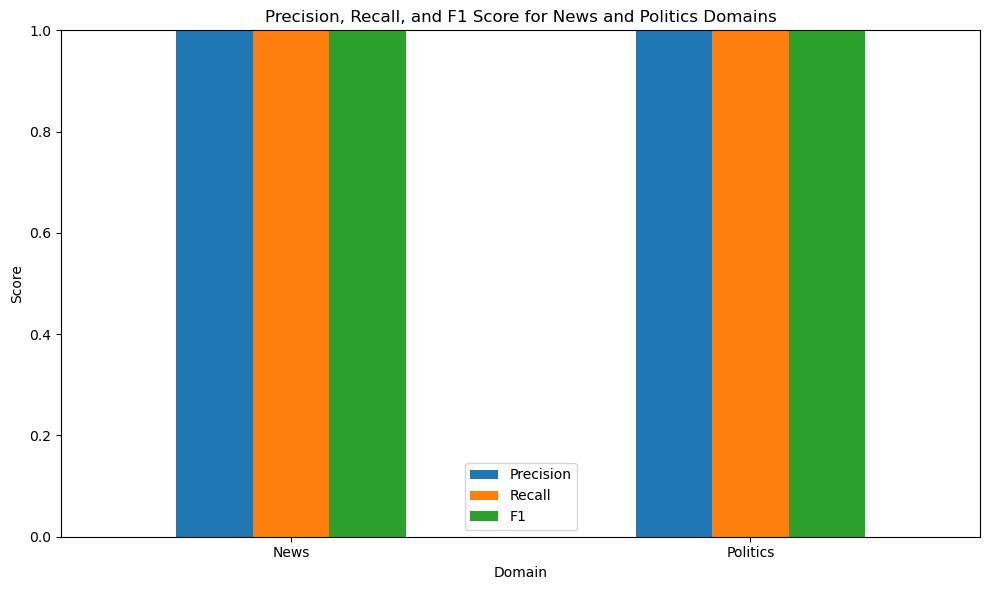

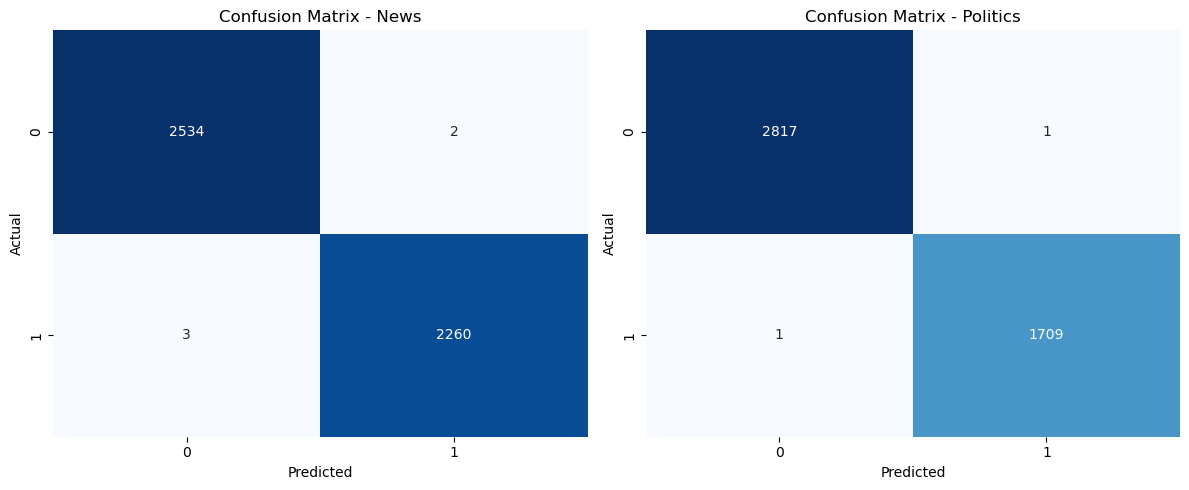

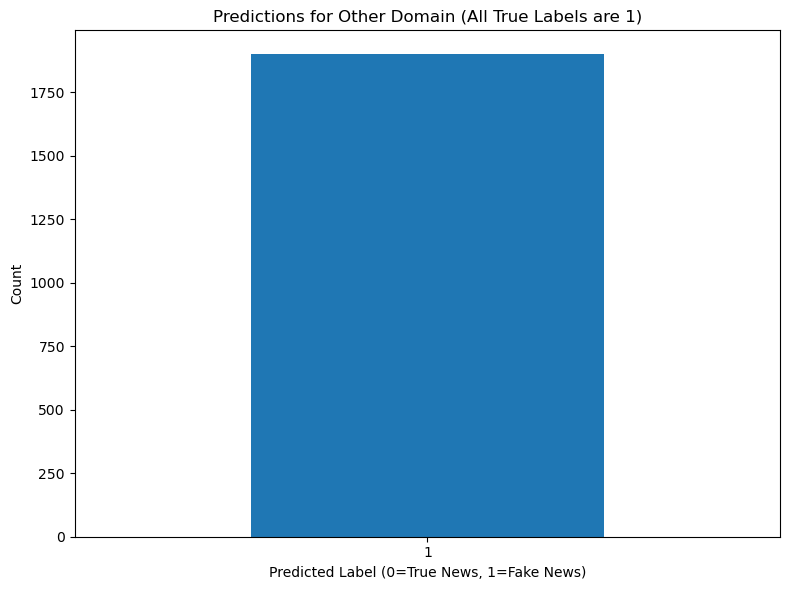


Feature Importance Analysis:


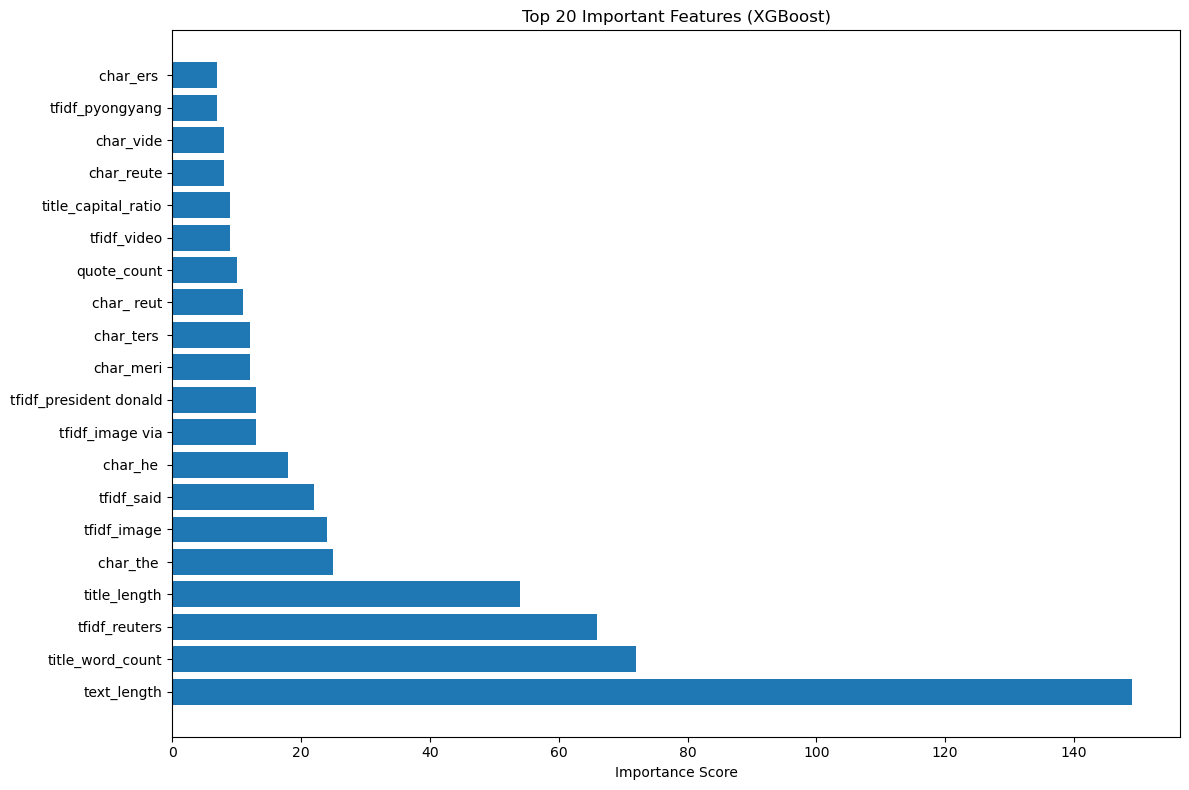

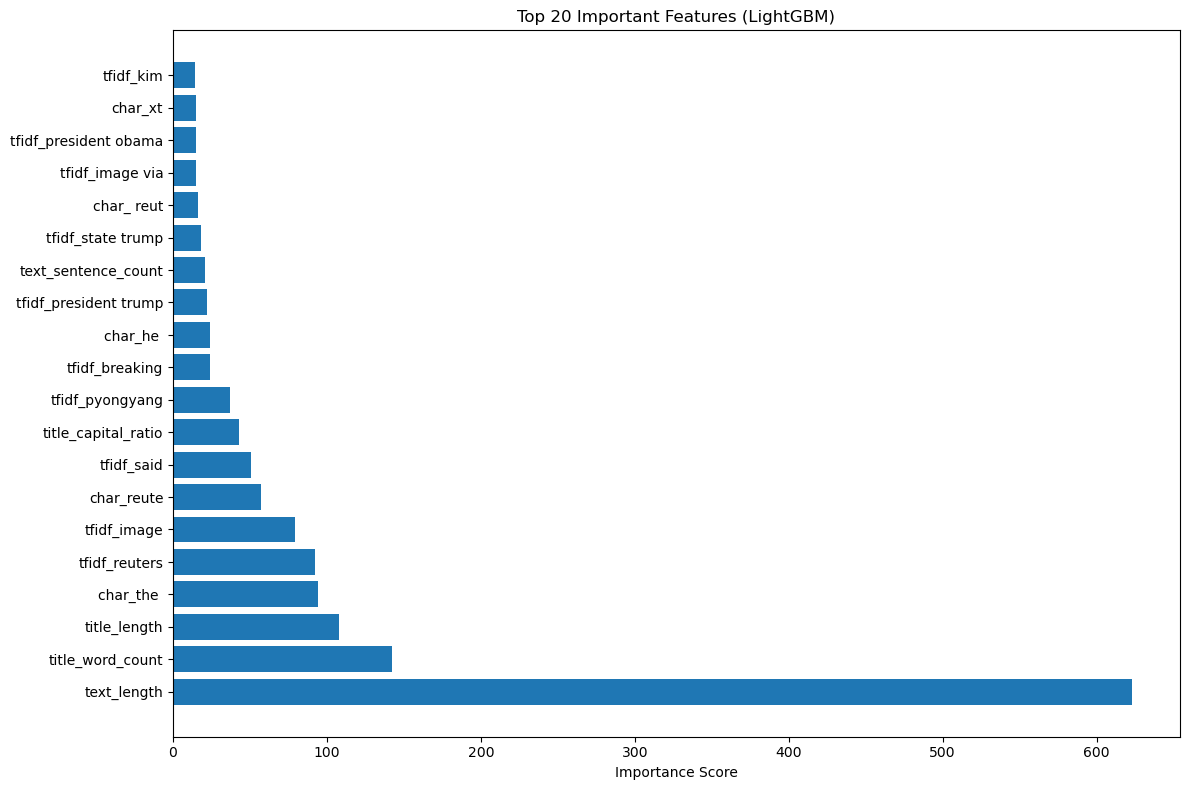

In [18]:
print("\nPerformance by Domain:")
domain_metrics = {}

# First analyze valid domains (News and Politics)
for domain in valid_domains:
    domain_data = test_results[test_results['subject'] == domain]
    if len(domain_data) > 0:
        domain_y_true = domain_data['true_label']
        domain_y_pred = domain_data['predicted_label']
        
        domain_accuracy = accuracy_score(domain_y_true, domain_y_pred)
        domain_precision = precision_score(domain_y_true, domain_y_pred)
        domain_recall = recall_score(domain_y_true, domain_y_pred)
        domain_f1 = f1_score(domain_y_true, domain_y_pred)
        
        domain_metrics[domain] = {
            'Accuracy': domain_accuracy,
            'Precision': domain_precision,
            'Recall': domain_recall,
            'F1': domain_f1
        }
        
        print(f"\n{domain} Domain:")
        print(f"  Accuracy: {domain_accuracy:.4f}")
        print(f"  Precision: {domain_precision:.4f}")
        print(f"  Recall: {domain_recall:.4f}")
        print(f"  F1 Score: {domain_f1:.4f}")

# Then analyze Other domain separately (only fake news)
other_data = test_results[test_results['subject'] == other_domain]
if len(other_data) > 0:
    other_y_true = other_data['true_label']
    other_y_pred = other_data['predicted_label']
    
    other_accuracy = accuracy_score(other_y_true, other_y_pred)
    
    print(f"\n{other_domain} Domain (Fake News Only):")
    print(f"  Accuracy: {other_accuracy:.4f}")
    print(f"  Note: This domain only contains fake news, so precision/recall/F1 are not applicable")
    
    # Add to metrics for visualization
    domain_metrics[other_domain] = {
        'Accuracy': other_accuracy,
        'Precision': np.nan,
        'Recall': np.nan,
        'F1': np.nan
    }

# Visualize domain-specific performance
metrics_df = pd.DataFrame(domain_metrics).T
plt.figure(figsize=(12, 8))

# Plot only the metrics that are valid for all domains
valid_metrics = ['Accuracy']
metrics_df[valid_metrics].plot(kind='bar', figsize=(10, 6))
plt.title('Accuracy Across Domains')
plt.ylabel('Score')
plt.xlabel('Domain')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Plot precision, recall, F1 only for valid domains
if len(valid_domains) > 0:
    plt.figure(figsize=(12, 8))
    metrics_df.loc[valid_domains, ['Precision', 'Recall', 'F1']].plot(kind='bar', figsize=(10, 6))
    plt.title('Precision, Recall, and F1 Score for News and Politics Domains')
    plt.ylabel('Score')
    plt.xlabel('Domain')
    plt.xticks(rotation=0)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Create confusion matrices for valid domains
plt.figure(figsize=(12, 5))
for i, domain in enumerate(valid_domains):
    domain_data = test_results[test_results['subject'] == domain]
    if len(domain_data) > 0:
        plt.subplot(1, 2, i+1)
        cm = pd.crosstab(domain_data['true_label'], domain_data['predicted_label'],
                         rownames=['Actual'], colnames=['Predicted'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {domain}')

plt.tight_layout()
plt.show()

# For the "Other" domain, show a simple bar chart of predictions
other_data = test_results[test_results['subject'] == other_domain]
if len(other_data) > 0:
    plt.figure(figsize=(8, 6))
    prediction_counts = other_data['predicted_label'].value_counts()
    prediction_counts.plot(kind='bar')
    plt.title(f'Predictions for {other_domain} Domain (All True Labels are 1)')
    plt.xlabel('Predicted Label (0=True News, 1=Fake News)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Feature importance analysis
print("\nFeature Importance Analysis:")

# Get feature names
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
char_feature_names = np.array(char_vectorizer.get_feature_names_out())
text_feature_names = np.array(text_features_df.columns)
domain_feature_names = np.array(['domain_encoded'])

all_feature_names = np.concatenate([
    [f"tfidf_{name}" for name in tfidf_feature_names],
    [f"char_{name}" for name in char_feature_names],
    text_feature_names,
    domain_feature_names
])

# Get XGBoost feature importance
xgb_importance = xgb_model.get_score(importance_type='weight')
xgb_importance_tuples = [(all_feature_names[int(k.replace('f', ''))], v) 
                         for k, v in xgb_importance.items() 
                         if int(k.replace('f', '')) < len(all_feature_names)]
xgb_sorted_importance = sorted(xgb_importance_tuples, key=lambda x: x[1], reverse=True)

# Get LightGBM feature importance
lgb_importance = lgb_model.feature_importance()
lgb_importance_tuples = [(all_feature_names[i], importance) 
                         for i, importance in enumerate(lgb_importance) 
                         if i < len(all_feature_names)]
lgb_sorted_importance = sorted(lgb_importance_tuples, key=lambda x: x[1], reverse=True)

# Plot top XGBoost features
plt.figure(figsize=(12, 8))
top_n = 20
top_features = xgb_sorted_importance[:top_n]
words = [item[0] for item in top_features]
scores = [item[1] for item in top_features]

plt.barh(range(len(words)), scores, align='center')
plt.yticks(range(len(words)), words)
plt.xlabel('Importance Score')
plt.title('Top 20 Important Features (XGBoost)')
plt.tight_layout()
plt.show()

# Plot top LightGBM features
plt.figure(figsize=(12, 8))
top_features = lgb_sorted_importance[:top_n]
words = [item[0] for item in top_features]
scores = [item[1] for item in top_features]

plt.barh(range(len(words)), scores, align='center')
plt.yticks(range(len(words)), words)
plt.xlabel('Importance Score')
plt.title('Top 20 Important Features (LightGBM)')
plt.tight_layout()
plt.show()

# Cross-Domain Performance by Domain

## Performance Metrics

| Domain         | Accuracy | Precision | Recall | F1 Score |
|----------------|----------|-----------|--------|----------|
| News           | 0.9990   | 0.9991    | 0.9987 | 0.9989   |
| Politics       | 0.9996   | 0.9994    | 0.9994 | 0.9994   |
| Other (Fake News Only) | 1.0000   | N/A       | N/A    | N/A      |

**Note**: The Other domain only contains fake news, so precision, recall, and F1 score are not applicable.